In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import os
import shap
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

C:\Users\19147\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import pandas as pd

# Load the CSV file
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
df = pd.read_csv(metadata_path)

# Display the first few rows of the dataframe 
df.head()


,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [3]:
#distribution of species
species_dist = df['species'].value_counts()
print(species_dist)

species
melodia        1256
polyglottos    1182
cardinalis     1074
migratorius    1017
bewickii        893
Name: count, dtype: int64


In [4]:
# Checking for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

id               0
genus            0
species          0
subspecies    3876
name             0
recordist        0
country          0
location         0
latitude        90
longitude       90
altitude        42
sound_type       0
source_url       0
license          0
time             0
date             0
remarks       1859
filename         0
dtype: int64


The primary input for generating spectrograms is the audio file itself. Missing values in metadata (like subspecies, latitude, longitude, altitude, and remarks) won't affect the generation of spectrograms, as long as the audio files (filename) are intact and not missing. 

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB
None


**Feature Extraction**

In [6]:

def load_bird_sound_paths_from_csv(metadata_path, audio_files_path):
    df = pd.read_csv(metadata_path)
    file_paths = []
    labels = []

    for index, row in df.iterrows():
        file_path = os.path.join(audio_files_path, row['filename'])
        if os.path.exists(file_path):
            file_paths.append(file_path)
            labels.append(row['species'])  # 'species' holds the label
        else:
            print(f"File not found: {file_path}")

    return file_paths, labels

# Usage
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
audio_files_path =  "C:/Users/19147/Downloads/archive (12)/wavfiles"

file_paths, labels = load_bird_sound_paths_from_csv(metadata_path, audio_files_path)
print(file_paths[:5], labels[:5])


['C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-0.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-1.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-4.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-5.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-6.wav'] ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [7]:
# New function to load and process audio files from paths
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        sound, _ = librosa.load(file_path, sr=sr)
        if len(sound) > fixed_length:
            sound = sound[:fixed_length]
        else:
            padding = fixed_length - len(sound)
            sound = np.pad(sound, (0, padding), 'constant')
        processed_audio.append(sound)
    return processed_audio

In [13]:


def extract_combined_features(file_path, sr):
    # Load the audio file first
    audio, sr = librosa.load(file_path, sr=sr)
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Extract Mel Spectrogram features
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec_mean = np.mean(mel_spec, axis=1)

    # Combine all features
    combined_features = np.concatenate((mfcc_mean, mel_spec_mean))
    return combined_features


In [11]:
sr = 22050  
features_list = [extract_combined_features(fp, sr) for fp in file_paths]
# Convert feature list to numpy array
features_array = np.array(features_list)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X3_train, X3_test, y3_train, y3_test, files_train, files_test = train_test_split(
    features_array, encoded_labels, file_paths, test_size=0.2, random_state=42
)

Accuracy: 0.8995391705069125
Classification Report:
              precision    recall  f1-score   support

    bewickii       0.94      0.85      0.89       193
  cardinalis       0.89      0.90      0.89       204
     melodia       0.83      0.92      0.87       243
 migratorius       0.91      0.93      0.92       207
 polyglottos       0.95      0.89      0.92       238

    accuracy                           0.90      1085
   macro avg       0.90      0.90      0.90      1085
weighted avg       0.90      0.90      0.90      1085



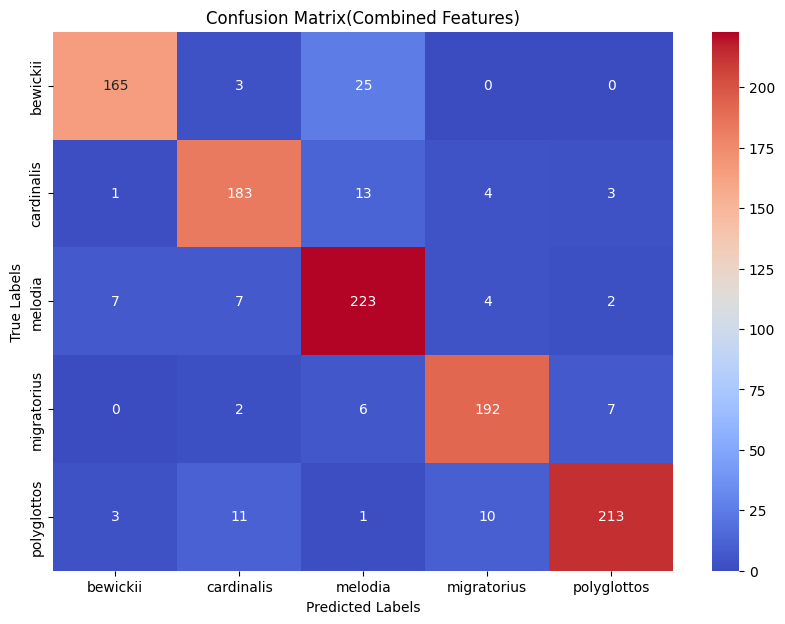

In [14]:

clf_combined = RandomForestClassifier(random_state=42)
clf_combined.fit(X3_train, y3_train)

Combined_predictions = clf_combined.predict(X3_test)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y3_test, Combined_predictions))
print("Classification Report:")
print(classification_report(y3_test, Combined_predictions, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y3_test, Combined_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel(' True Labels ')
plt.title('Confusion Matrix(Combined Features)')
plt.show()


The classification model shows a high overall accuracy of 90%, indicating strong performance in identifying bird species. Specifically, 'migratorius' and 'polyglottos' exhibit the best precision scores, at 91% and 95% respectively, highlighting their reliability in predictions. Notably, both also achieves the highest F1-score of 92%, suggesting an excellent balance between precision and recall. Each species shows consistently high performance, with F1-scores ranging from 87% to 92%, underscoring the model's effectiveness across different types of bird calls. This robust performance makes the model highly suitable for applications requiring precise bird species identification.

In [15]:
# Calculate probabilities and find maximum confidence predictions
probs = clf_combined.predict_proba(X3_test)
max_probs = np.max(probs, axis=1)

# Top 10, bottom 10, and incorrect indices
top_10_indices = np.argsort(-max_probs)[:10]
print("top 10 indices:",top_10_indices)
bottom_10_indices = np.argsort(max_probs)[:10]
print("bottom_10_indices:", bottom_10_indices)
incorrect_indices = np.where(Combined_predictions != y3_test)[0]
print("incorrect indices:",incorrect_indices)

top 10 indices: [ 266 1052  714  319  259  216  758  430  560  497]
bottom_10_indices: [ 324  962  576  927  907  477 1018  158  188  876]
incorrect indices: [  27   64   69   82   89  101  106  109  119  122  129  132  133  136
  141  158  162  171  173  179  184  188  200  204  205  217  221  228
  255  263  270  287  295  303  321  332  334  336  359  363  364  375
  402  404  406  410  413  436  438  445  452  453  455  459  477  529
  555  558  562  572  574  579  585  586  588  590  609  622  645  652
  655  662  674  680  683  688  705  721  722  747  750  762  768  779
  783  786  807  817  825  832  833  860  862  876  887  889  893  921
  940  946  969  974  978 1018 1049 1051 1060 1061 1068]


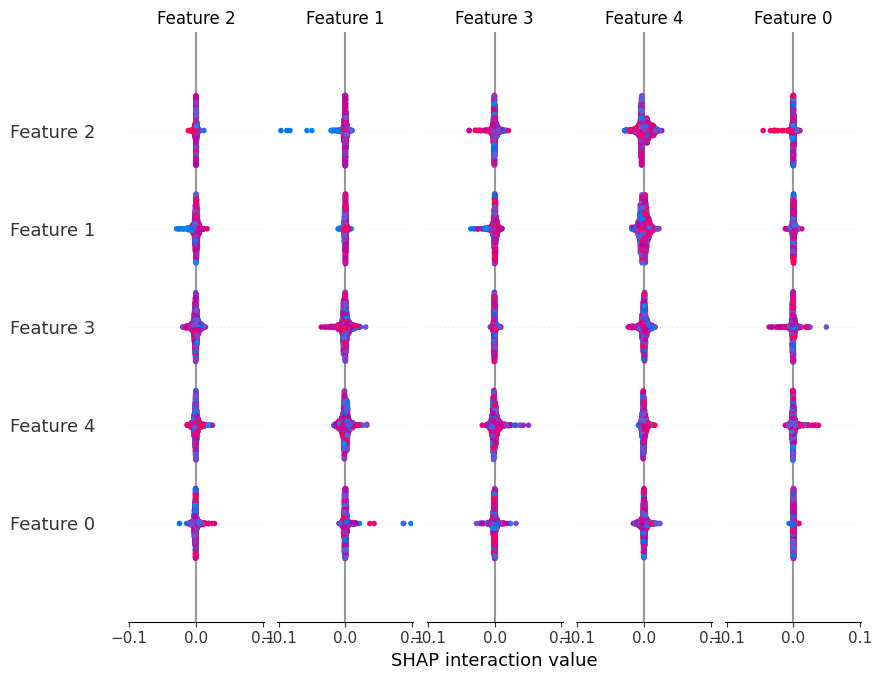

In [17]:

X3_test = np.array(X3_test)

# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(clf_combined)
shap_values = explainer.shap_values(X3_test)
# Plot summary of SHAP values
shap.summary_plot(shap_values, X3_test)


The SHAP interaction values plot visualizes how pairs of features derived from combined mel spectrogram and MFCC (Mel-Frequency Cepstral Coefficients) features interact and contribute to the predictions of bird sound classification model. Each column in the plot represents the interaction of features, with the x-axis showing SHAP interaction values and the y-axis listing the interacting features. Most SHAP values are centered around zero, suggesting that for the majority of data points, these feature interactions do not significantly alter the model’s predictions. Notably, interactions involving Features 1 and 4 show some outliers, indicating that in certain instances, these interactions have a substantial impact on the model's output. The spread in SHAP values, especially for Feature 4, suggests a higher influence on predictions in specific cases. Overall, while most feature interactions have a relatively balanced effect, understanding these interactions can provide valuable insights for feature engineering and model optimization to enhance classification performance.

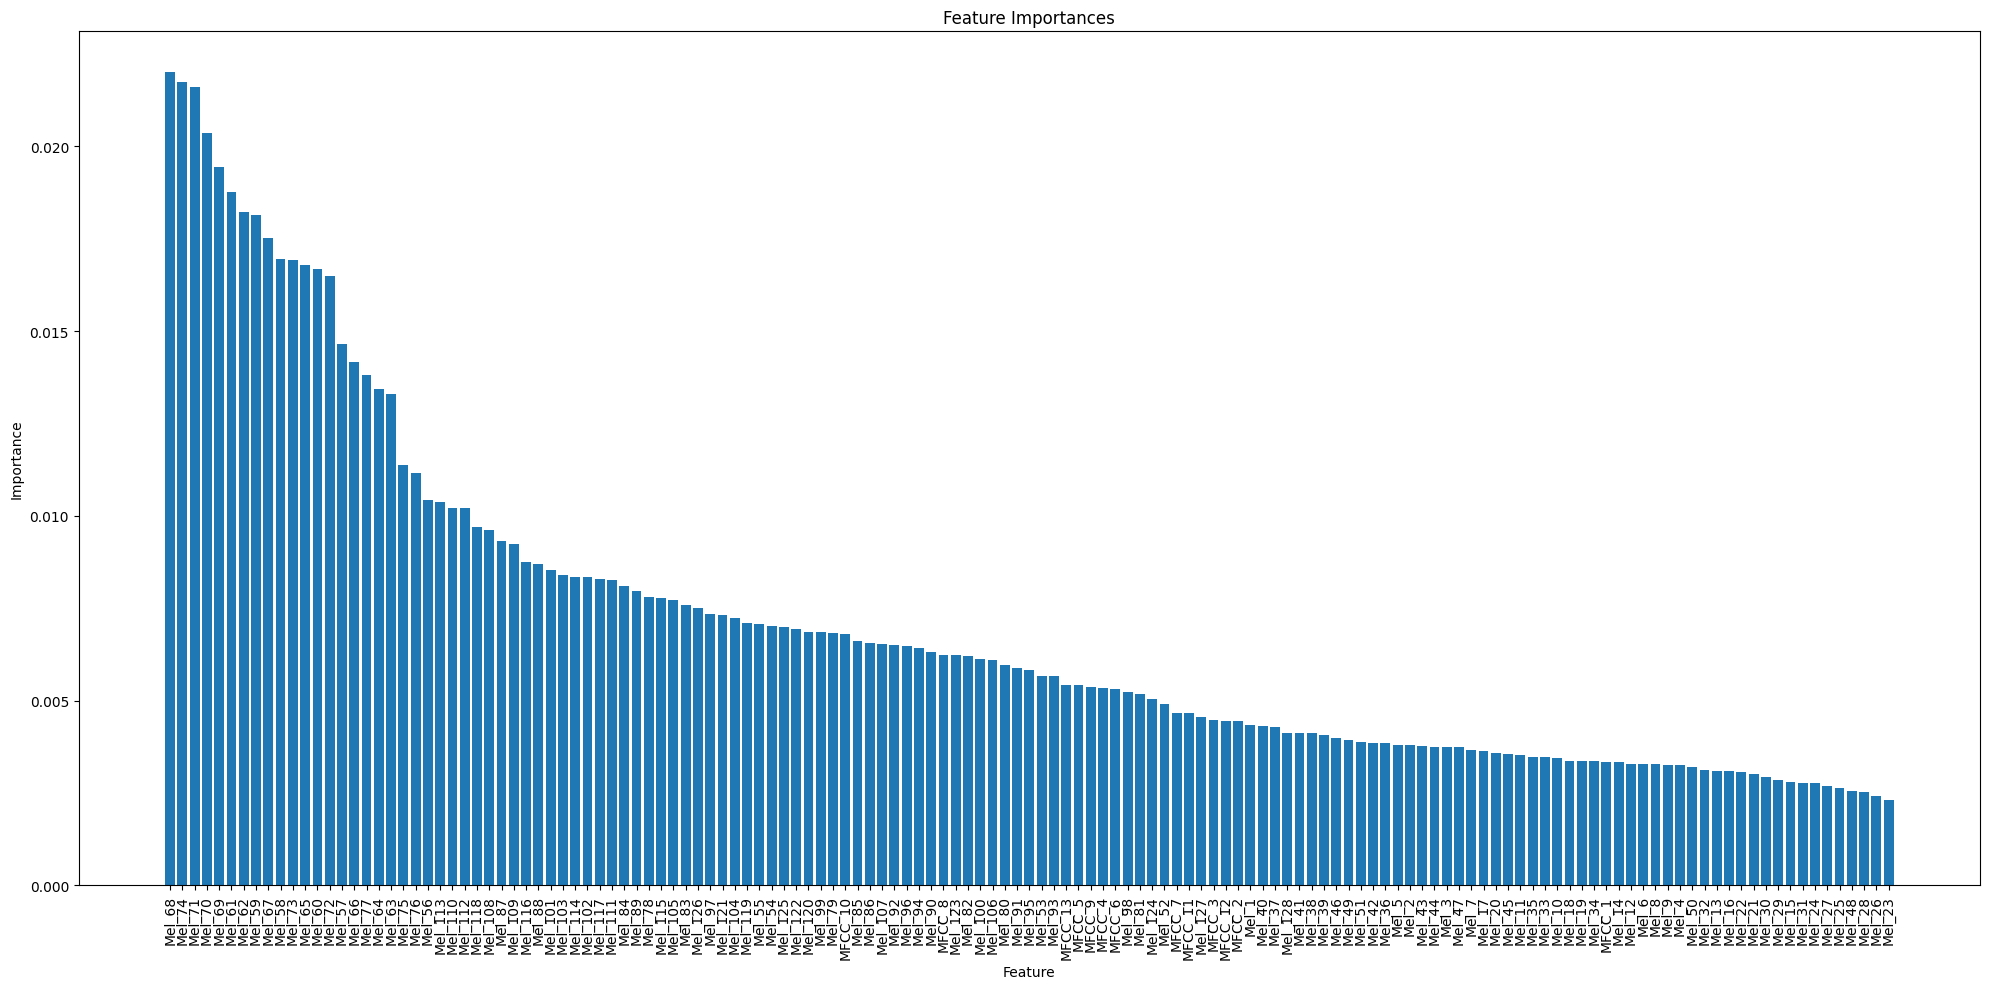

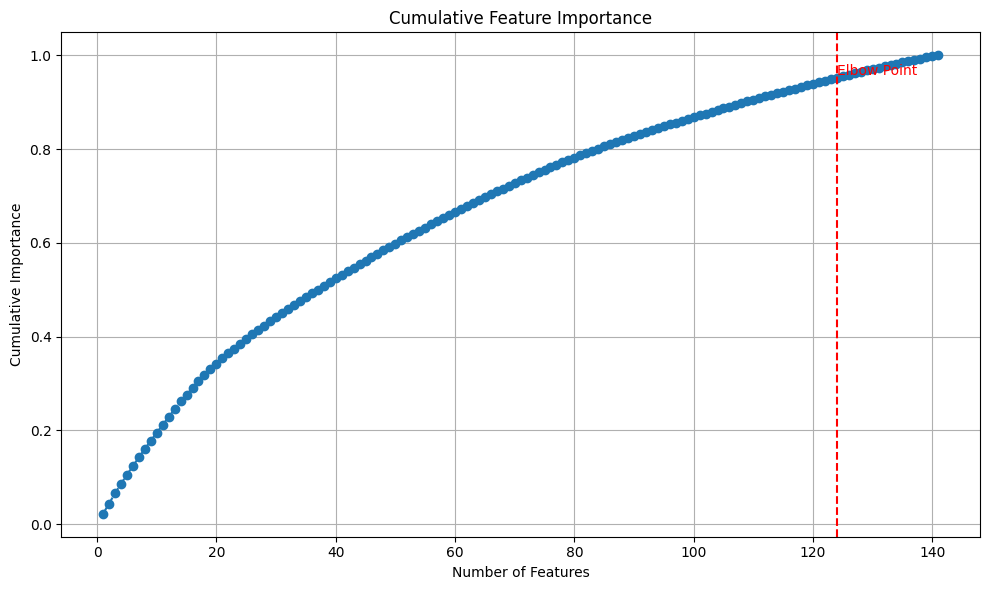

Elbow Point (95% cumulative importance): 124 features


In [18]:


# Define feature names with consistent indexing (1-based for display clarity)
feature_names = ['MFCC_{}'.format(i + 1) for i in range(13)] + \
                ['Mel_{}'.format(i + 1) for i in range(128)] 

# Assuming clf_combined is your trained model with combined features
importances = clf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices by importance

# Plotting all features
plt.figure(figsize=(20, 10))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

# Calculate cumulative importance
cumulative_importance = np.cumsum(importances[indices])

# Plot cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)

# Identify the elbow point (e.g., 95% cumulative importance)
elbow_point = np.argmax(cumulative_importance >= 0.95) + 1  # 95% threshold
plt.axvline(x=elbow_point, color='r', linestyle='--')
plt.text(elbow_point, cumulative_importance[elbow_point - 1], 'Elbow Point', color='r', verticalalignment='bottom')

plt.tight_layout()
plt.show()

print(f"Elbow Point (95% cumulative importance): {elbow_point} features")


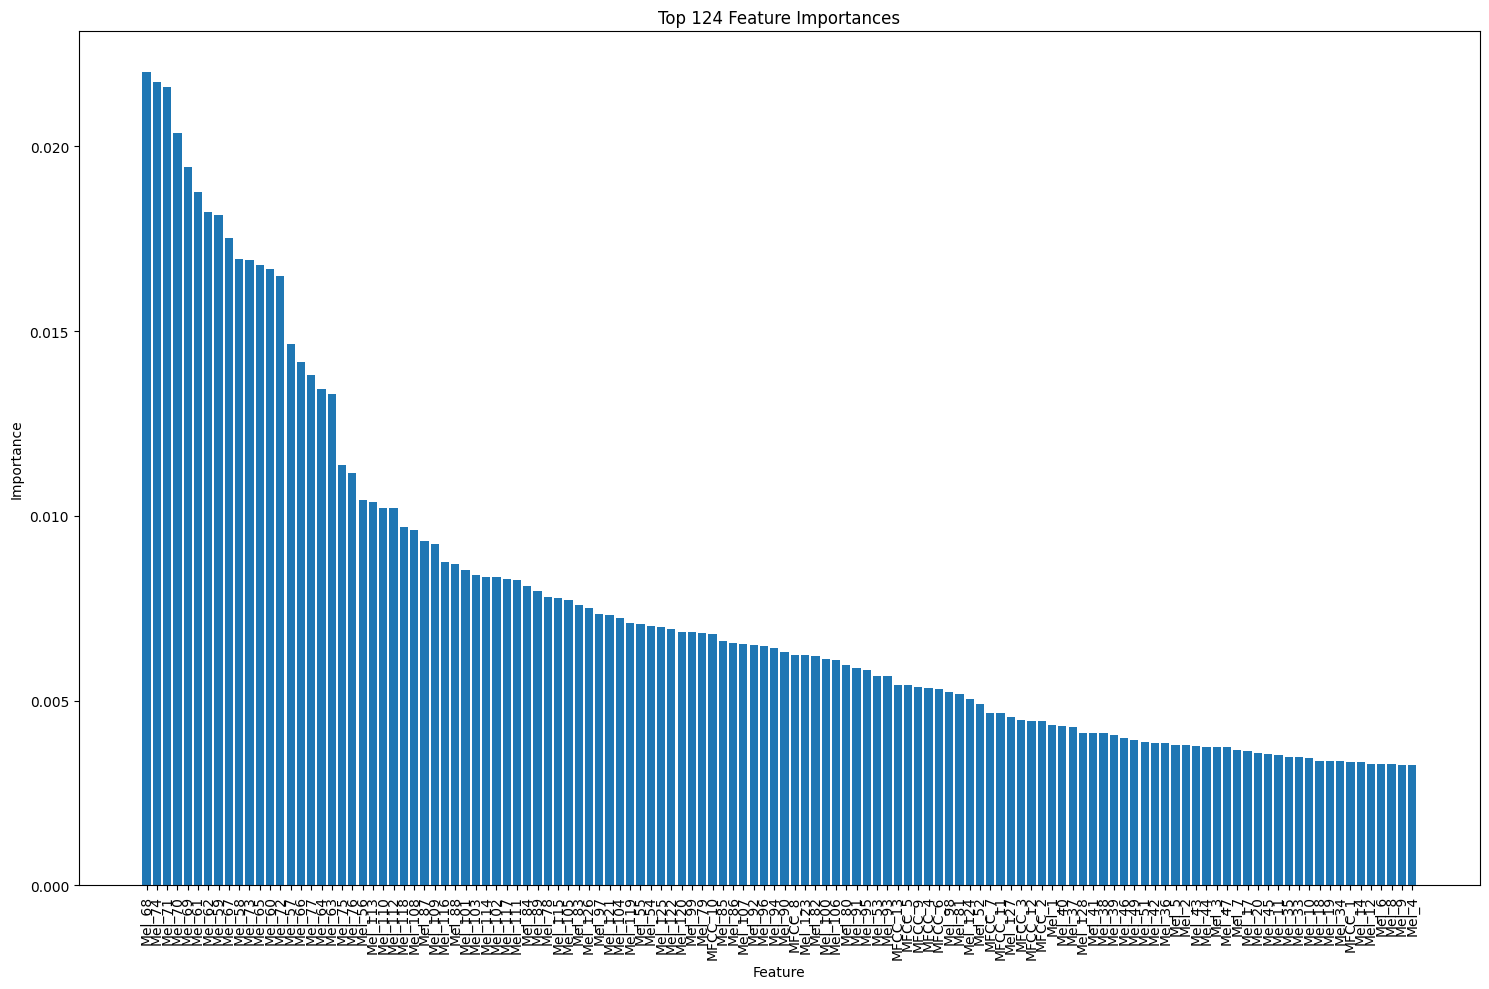

In [32]:
# Define feature names starting from 1
feature_names = ['MFCC_{}'.format(i + 1) for i in range(13)] + \
                ['Mel_{}'.format(i + 1) for i in range(128)]

# Assuming clf_combined is your trained model with combined features
importances = clf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices by importance

# Define the number of features to display
N = 124

# Plotting top N features
plt.figure(figsize=(15, 10))
plt.bar(range(N), importances[indices[:N]], align='center')
plt.xticks(range(N), [feature_names[i] for i in indices[:N]], rotation=90)
plt.title(f'Top {N} Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [33]:

def plot_spectrogram_feature(audio, sr, feature_idx, feature_type, title):
    if feature_type == 'MFCC':
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        feature = mfcc[feature_idx, :]
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc, sr=sr, x_axis='time')
        plt.colorbar()
        plt.title(f'{title} - {feature_type}_{feature_idx}')
        plt.tight_layout()
        plt.show()
    elif feature_type == 'Mel':
        # Adjust index for Mel features as they start after MFCC features
        mel_index = feature_idx - 13
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'{title} - {feature_type}_{mel_index}')
        plt.tight_layout()
        plt.show()


Top 10 Combined Feature Importances:


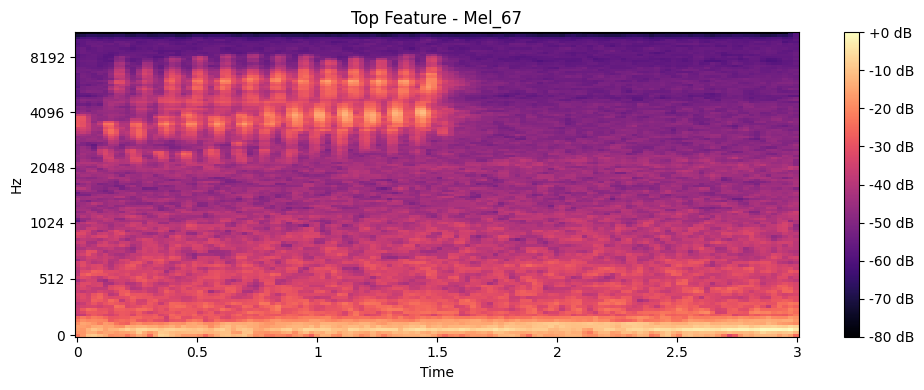

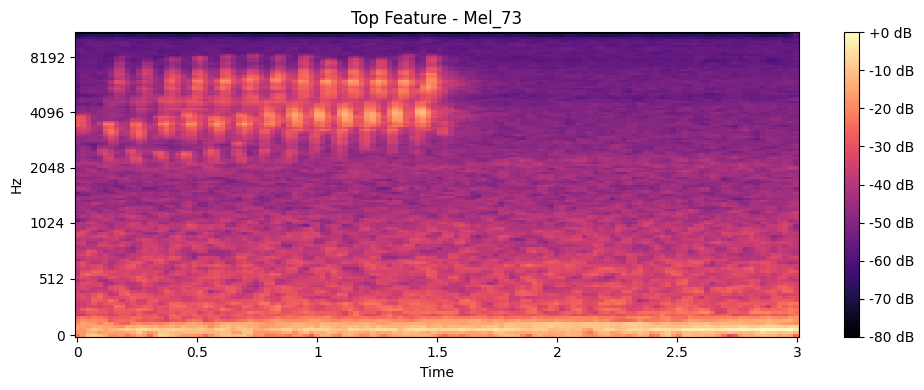

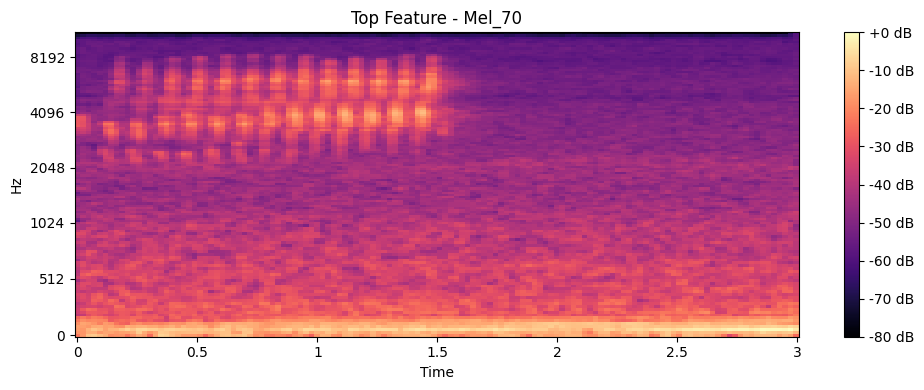

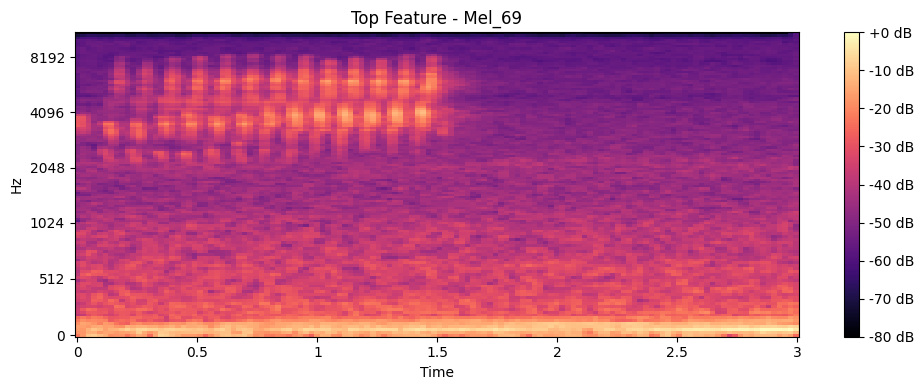

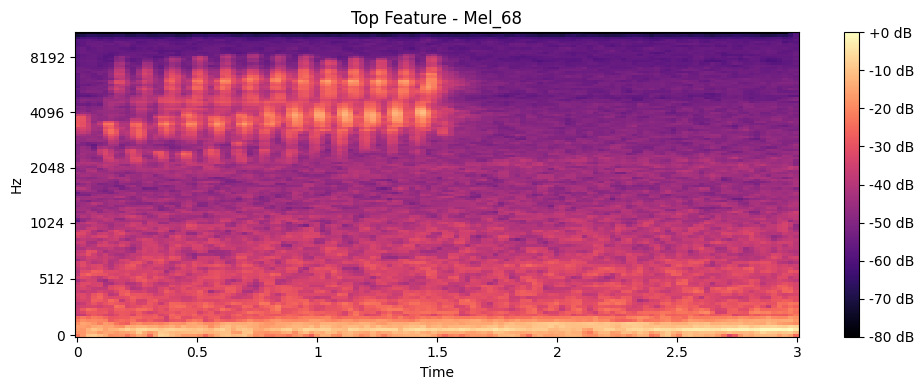

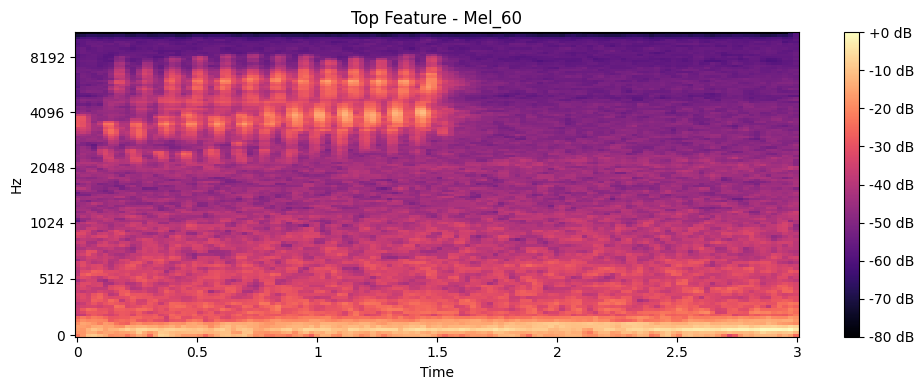

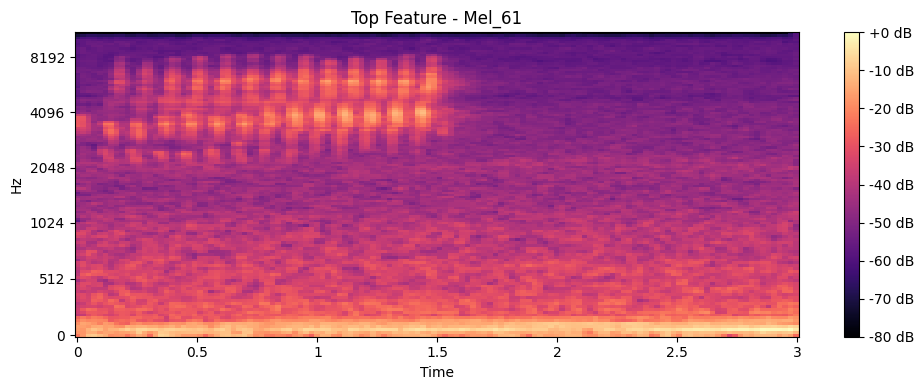

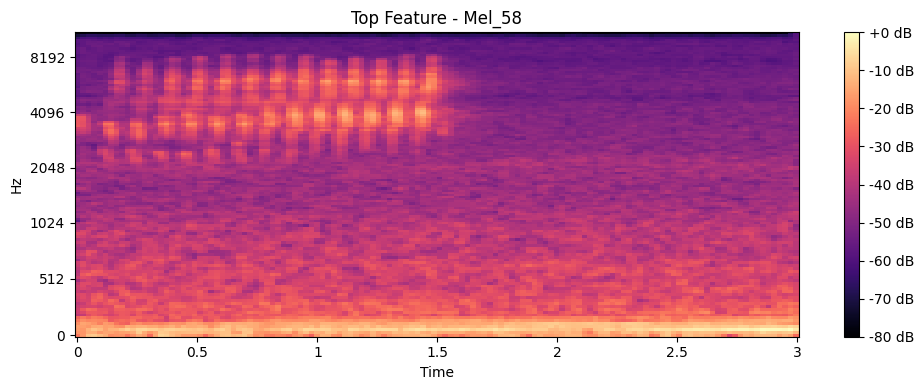

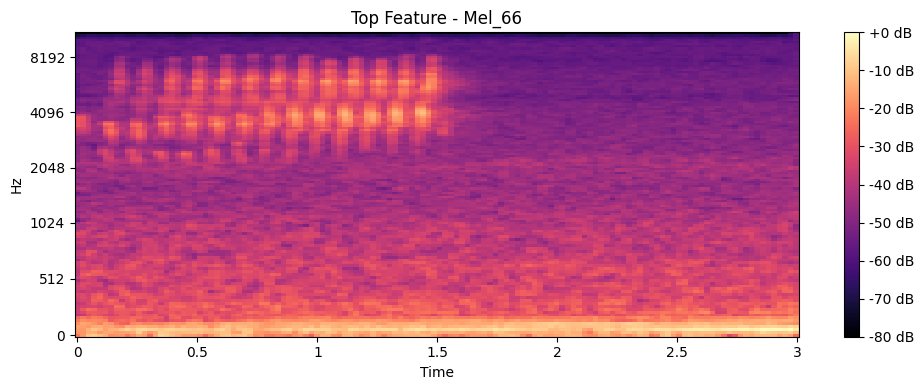

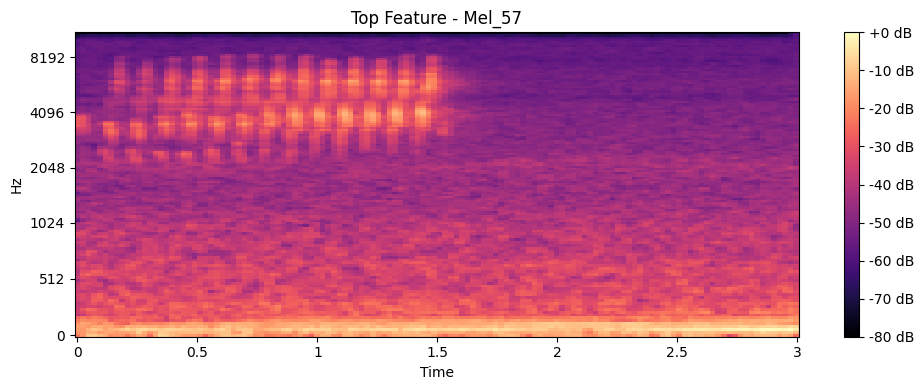

Bottom 10 Combined Feature Importances:


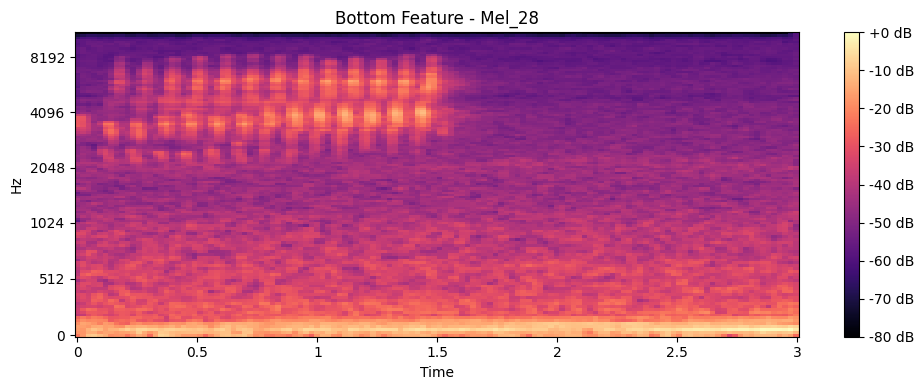

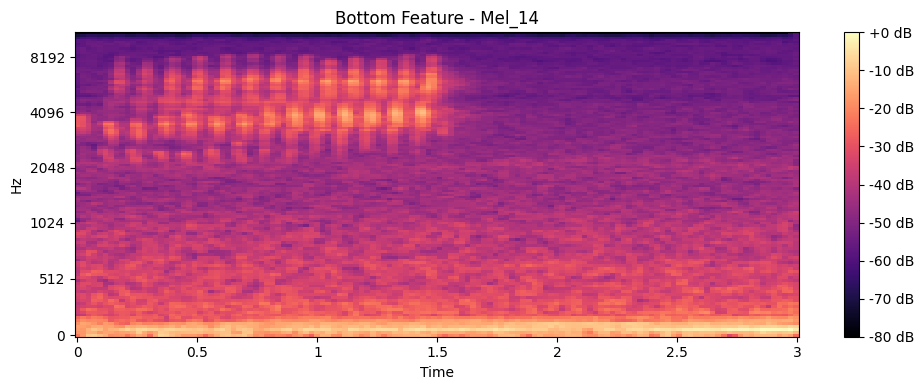

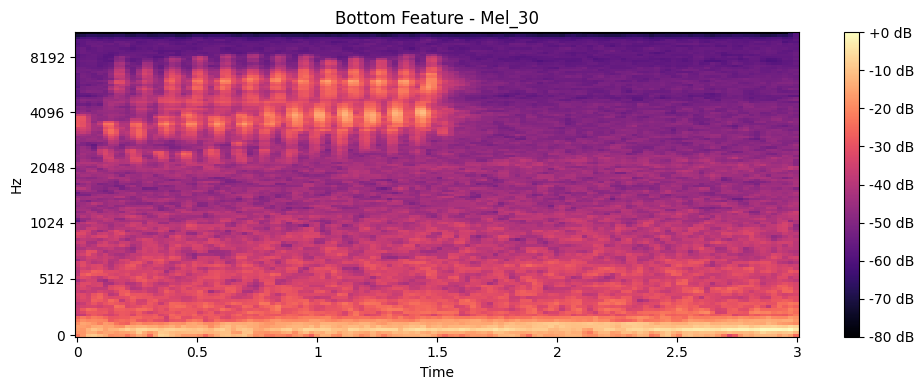

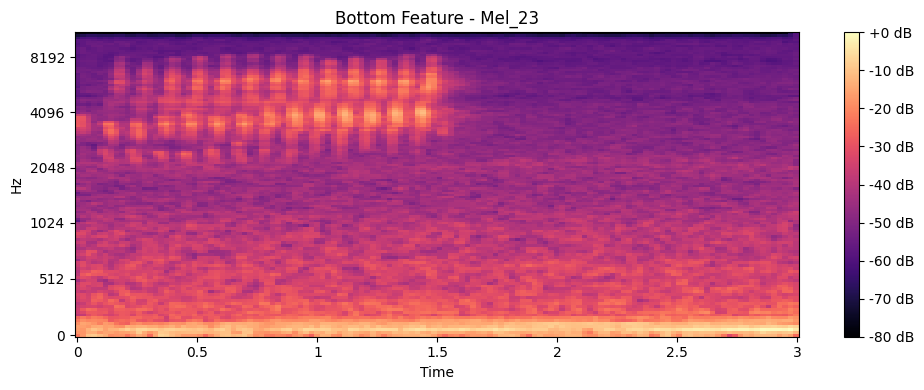

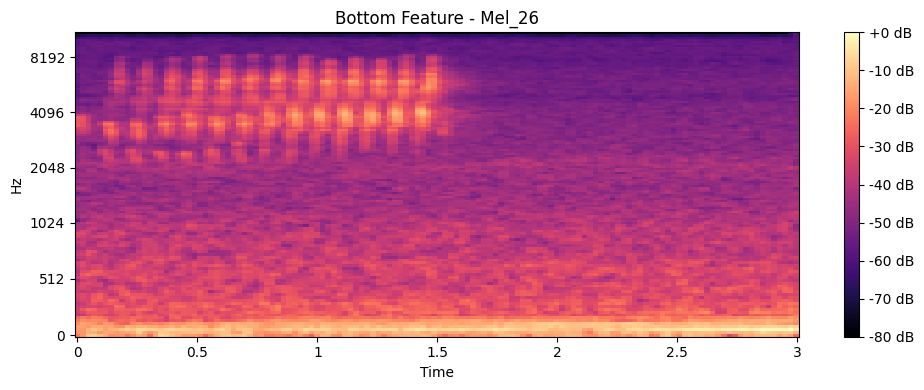

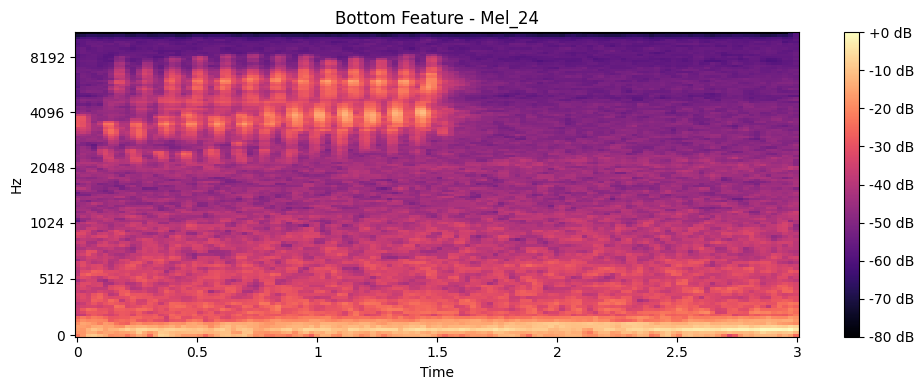

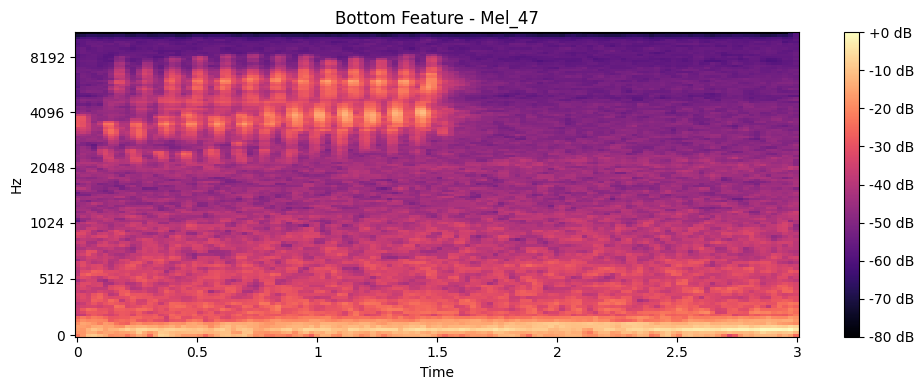

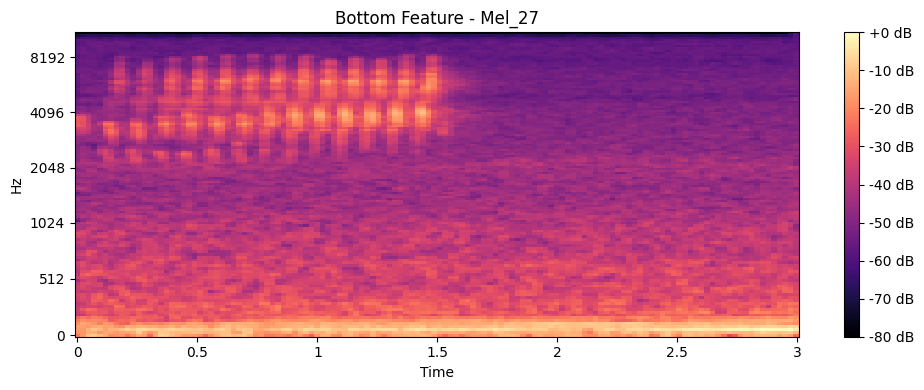

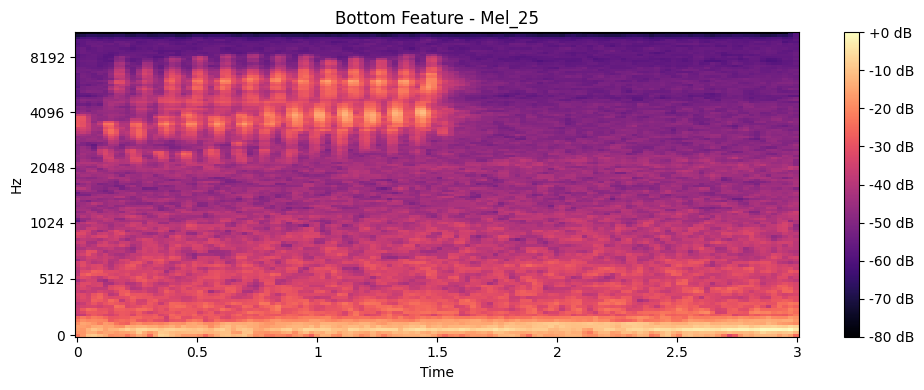

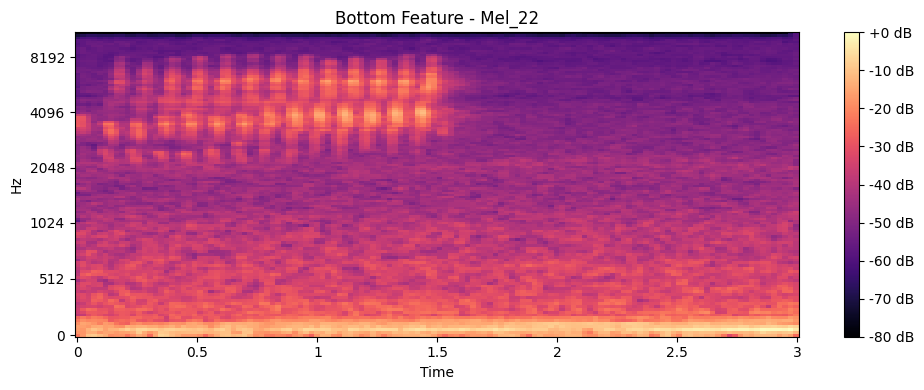

In [34]:
# Example audio file (adjust to your context)
example_audio_path = file_paths[0]
audio, sr = librosa.load(example_audio_path, sr=22050)

print("Top 10 Combined Feature Importances:")
for i in top_combined_indices:
    feature_type = 'MFCC' if i < 13 else 'Mel'
    plot_spectrogram_feature(audio, sr, i, feature_type, 'Top Feature')

print("Bottom 10 Combined Feature Importances:")
for i in bottom_combined_indices:
    feature_type = 'MFCC' if i < 13 else 'Mel'
    plot_spectrogram_feature(audio, sr, i, feature_type, 'Bottom Feature')


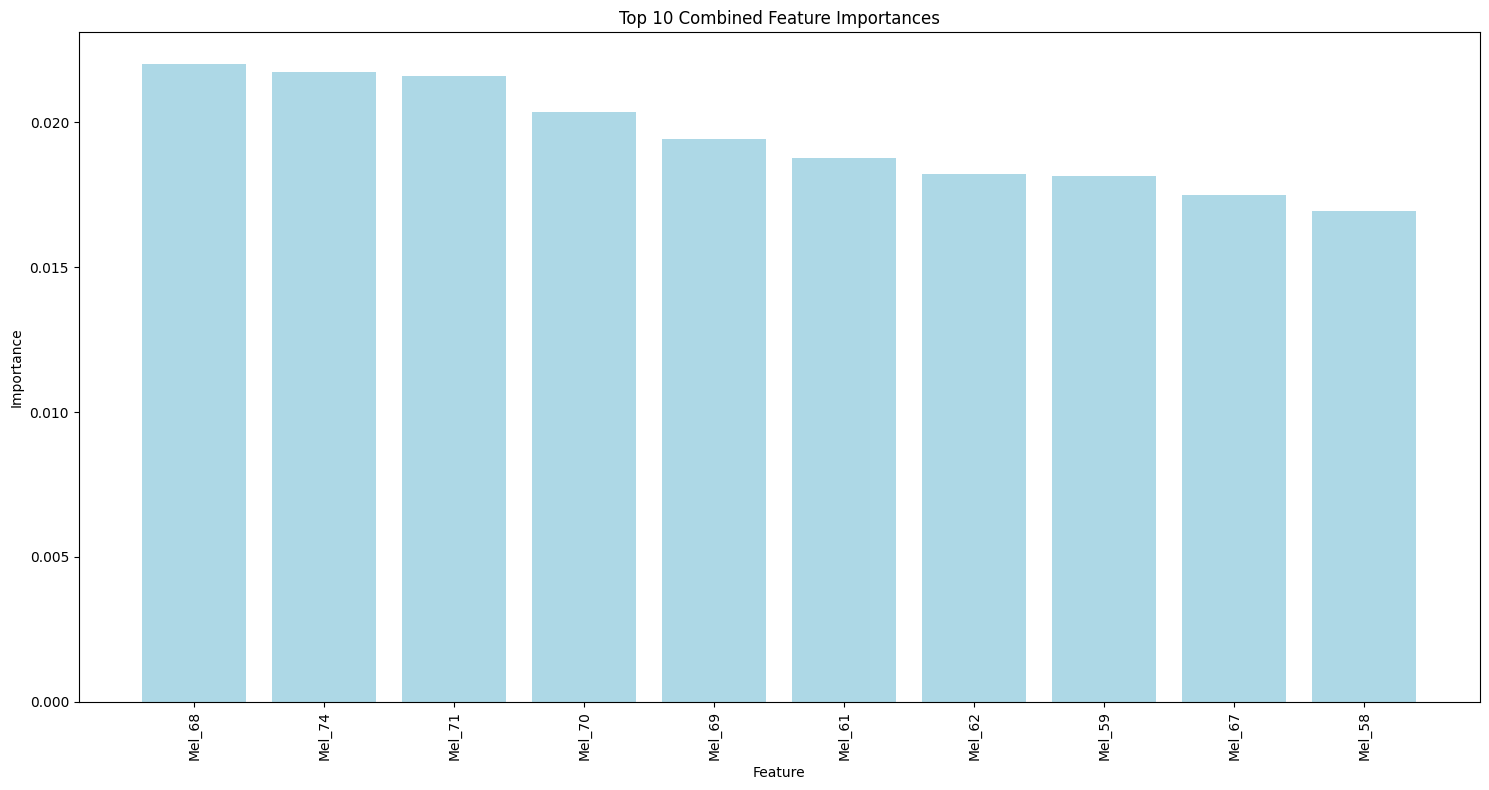

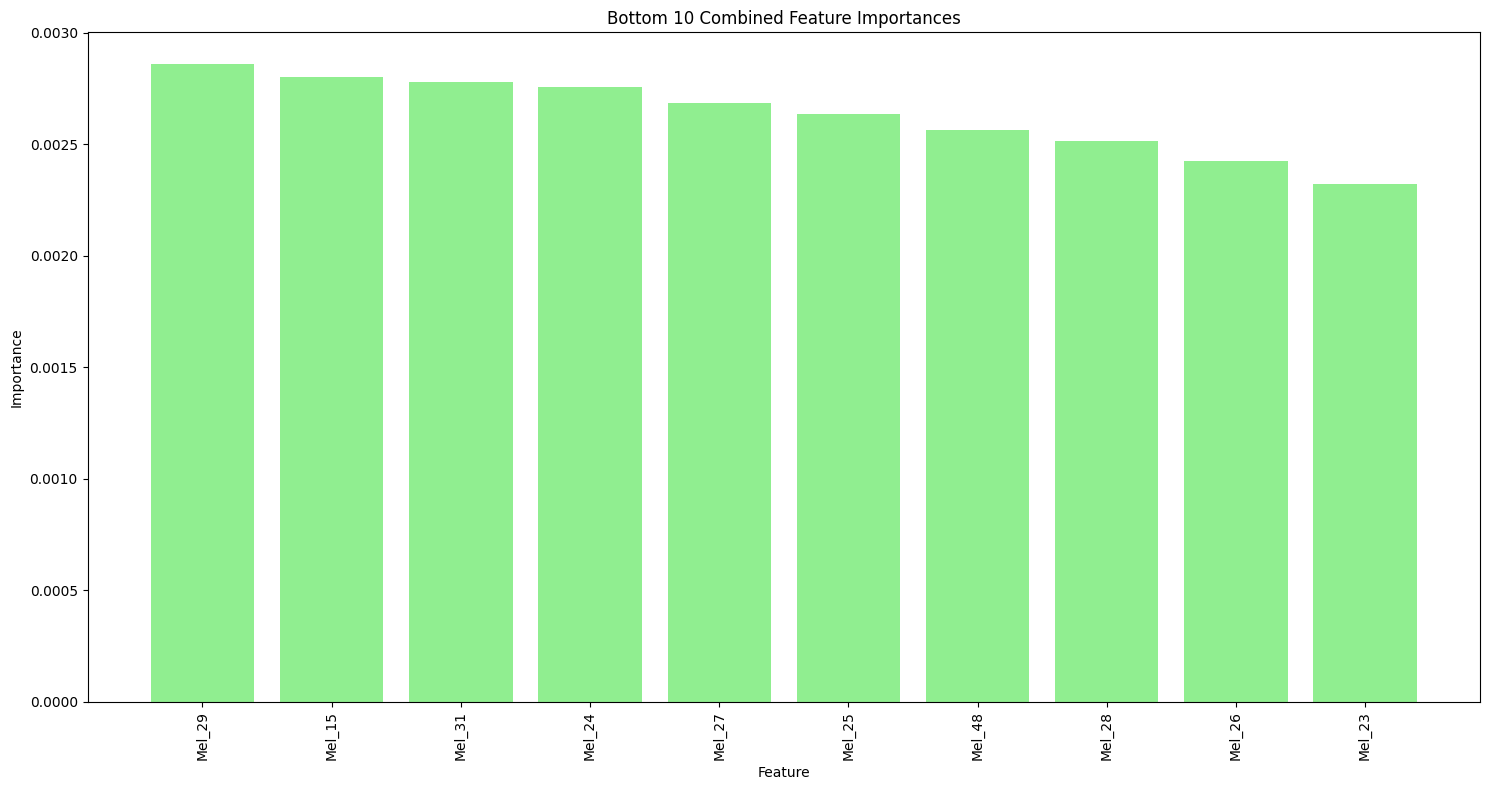

In [35]:

# Define feature names starting from 1
feature_names = ['MFCC_{}'.format(i + 1) for i in range(13)] + \
                ['Mel_{}'.format(i + 1) for i in range(128)] 

# Assuming clf_combined is your trained model with combined features
importances = clf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices by importance

# Get the top 10 features
top_combined_indices = indices[:10]

# Get the bottom 10 features
bottom_combined_indices = indices[-10:]

# Plotting top 10 combined features
plt.figure(figsize=(15, 8))
plt.bar(range(10), importances[top_combined_indices], align='center', color='lightblue')
plt.xticks(range(10), [feature_names[i] for i in top_combined_indices], rotation=90)
plt.title('Top 10 Combined Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

# Plotting bottom 10 combined features
plt.figure(figsize=(15, 8))
plt.bar(range(10), importances[bottom_combined_indices], align='center', color='lightgreen')
plt.xticks(range(10), [feature_names[i] for i in bottom_combined_indices], rotation=90)
plt.title('Bottom 10 Combined Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


In [26]:

y3_scores = clf_combined.predict_proba(X3_test)

In [27]:
# Binarize the labels
y3_test_binarized = label_binarize(y3_test, classes=np.unique(y3_train))

In [28]:
n_classes = y3_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y3_test_binarized[:, i], y3_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

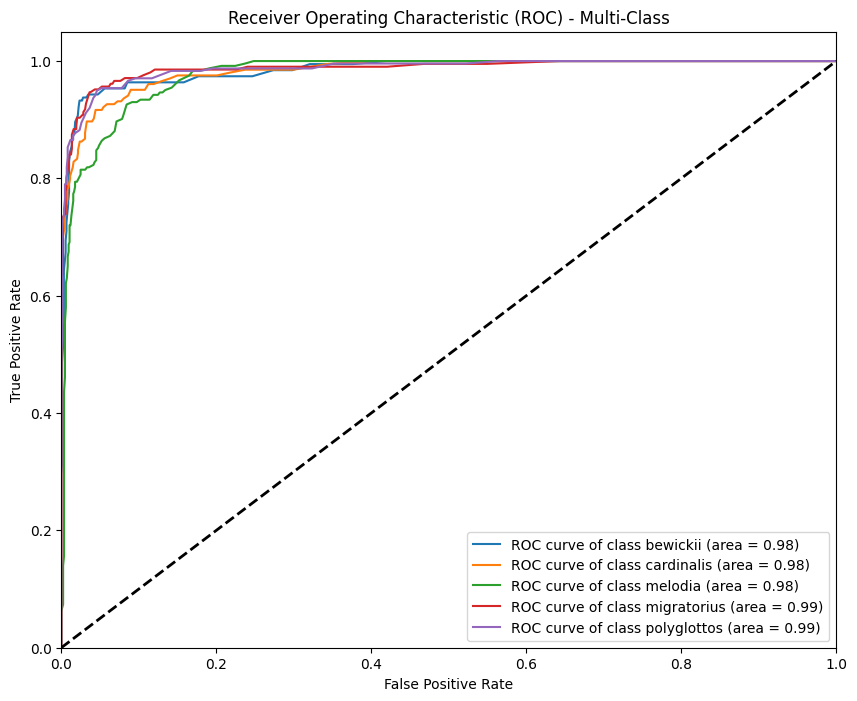

In [29]:
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc="lower right")
plt.show()


The ROC curve shown represents how well my model can identify different bird species from their sounds. Each line on the graph stands for a different bird species. The closer these lines are to the top-left corner of the chart, the better my model is at identifying that specific bird species correctly.

The chart uses Area Under the Curve, to show how accurate the predictions are. The values range from 0.98 to 0.99 for different species, which is really high. This means that my model does an excellent job at figuring out which sounds belong to which species, with very few mistakes.

The line going diagonally from the bottom left to the top right represents a guesswork model, just randomly guessing the bird species. My model's lines are way above this diagonal line, which tells us that it's doing much better than just guessing.

Two species, labeled as "migratorius," and "polyglottos" has an AUC of 0.99, which is the highest among the species tested. This means the model is almost perfect at identifying this species. The other species have AUC values of 0.98, which are also very good but slightly lower than the "migratorius."

Overall, this graph shows that my model is reliable and effective in recognizing bird species from sounds.